<a href="https://colab.research.google.com/github/efvillar/Ejemplos_GAN/blob/master/2_Explore_Latent_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eploracion del Espacio Latente

### Librerias

In [1]:
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

In [14]:
!pip install -q kaggle

###  Montar Drive y bajar datos de Kaggle

In [19]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'datos/celebridades/'


Mounted at /content/drive


In [21]:
print(base_dir)

/content/drive/My Drive/datos/celebridades/


In [22]:
import os

os.environ['KAGGLE_USERNAME'] = "edwinvillarraga" # username from the json file
os.environ['KAGGLE_KEY'] = "593a3c77ae23eabdf087e179d9038b70" # key from the json file

In [30]:
!kaggle datasets download 'jessicali9530/celeba-dataset' -p '/content/drive/My Drive/datos/celebridades/'

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [32]:
!ls '/content/drive/My Drive/datos/celebridades/'

celeba-dataset.zip


In [33]:
!unzip '/content/drive/My Drive/datos/celebridades/celeba-dataset.zip' -d '/content/drive/My Drive/datos/celebridades/'

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/197612.jpg  
  inflating:

In [53]:
#!ls '/content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/'

### Transofrmación de las imágenes en un archivo comprimido tipo numpy

In [34]:
# Se instala un modelo preentrenado para seleccionar solo los rostros de las imágenes en un cuadro y eliminar fondos
!pip install mtcnn

     |████████████████████████████████| 2.3MB 17.6MB/s 


In [37]:
# confirm mtcnn was installed correctly
import mtcnn
# show version
print(mtcnn.__version__)

0.1.0


In [40]:
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN

"""
# prepare model
model = MTCNN()
# detect face in the image
faces = model.detect_faces(pixels)
# extract details of the face
x1, y1, width, height = faces[0]['box']
"""

"\n# prepare model\nmodel = MTCNN()\n# detect face in the image\nfaces = model.detect_faces(pixels)\n# extract details of the face\nx1, y1, width, height = faces[0]['box']\n"

In [42]:
# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
    # detect face in the image
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    # extract details of the face
    x1, y1, width, height = faces[0]["box"]
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

In [43]:
# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    # prepare model
    model = MTCNN()
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # load the image
        pixels = load_image(directory + filename)
        # get face
        face = extract_face(model, pixels)
        if face is None:
            continue
        # store
        faces.append(face)
        print(len(faces), face.shape)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)

In [45]:
# example of extracting and resizing faces into a new dataset
from os import listdir
from numpy import asarray
from numpy import savez_compressed
from PIL import Image
from mtcnn.mtcnn import MTCNN

# load an image as an rgb numpy array
def load_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    # convert to array
    pixels = asarray(image)
    return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
    # detect face in the image
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces):
    # prepare model
    model = MTCNN()
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # load the image
        pixels = load_image(directory + filename)
        # get face
        face = extract_face(model, pixels)
        if face is None:
            continue
        # store
        faces.append(face)
        print(len(faces), face.shape)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)

In [55]:
# directory that contains all images - load only 10.000
directory = '/content/drive/My Drive/datos/celebridades/img_align_celeba/img_align_celeba/'
# load and extract all faces
all_faces = load_faces(directory, 10000)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('/content/drive/My Drive/datos/celebridades/img_align_celeba.npz', all_faces)

Se han truncado las últimas 5000 líneas del flujo de salida.
5002 (80, 80, 3)
5003 (80, 80, 3)
5004 (80, 80, 3)
5005 (80, 80, 3)
5006 (80, 80, 3)
5007 (80, 80, 3)
5008 (80, 80, 3)
5009 (80, 80, 3)
5010 (80, 80, 3)
5011 (80, 80, 3)
5012 (80, 80, 3)
5013 (80, 80, 3)
5014 (80, 80, 3)
5015 (80, 80, 3)
5016 (80, 80, 3)
5017 (80, 80, 3)
5018 (80, 80, 3)
5019 (80, 80, 3)
5020 (80, 80, 3)
5021 (80, 80, 3)
5022 (80, 80, 3)
5023 (80, 80, 3)
5024 (80, 80, 3)
5025 (80, 80, 3)
5026 (80, 80, 3)
5027 (80, 80, 3)
5028 (80, 80, 3)
5029 (80, 80, 3)
5030 (80, 80, 3)
5031 (80, 80, 3)
5032 (80, 80, 3)
5033 (80, 80, 3)
5034 (80, 80, 3)
5035 (80, 80, 3)
5036 (80, 80, 3)
5037 (80, 80, 3)
5038 (80, 80, 3)
5039 (80, 80, 3)
5040 (80, 80, 3)
5041 (80, 80, 3)
5042 (80, 80, 3)
5043 (80, 80, 3)
5044 (80, 80, 3)
5045 (80, 80, 3)
5046 (80, 80, 3)
5047 (80, 80, 3)
5048 (80, 80, 3)
5049 (80, 80, 3)
5050 (80, 80, 3)
5051 (80, 80, 3)
5052 (80, 80, 3)
5053 (80, 80, 3)
5054 (80, 80, 3)
5055 (80, 80, 3)
5056 (80, 80, 3)
5057

In [58]:
!ls '/content/drive/My Drive/datos/celebridades/' -l


total 1609853
-rw------- 1 root root 1427750792 Dec 23 21:31 celeba-dataset.zip
drwx------ 3 root root       4096 Dec 23 21:34 img_align_celeba
-rw------- 1 root root  177660744 Dec 24 01:49 img_align_celeba.npz
-rw------- 1 root root   24913339 Oct  1  2019 list_attr_celeba.csv
-rw------- 1 root root    5390926 Oct  1  2019 list_bbox_celeba.csv
-rw------- 1 root root    2836404 Oct  1  2019 list_eval_partition.csv
-rw------- 1 root root    9932092 Oct  1  2019 list_landmarks_align_celeba.csv


### Definición de Modelo Discriminador, Generador y Conjunto

In [90]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding="same", input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x30
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="sigmoid"))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation="tanh", padding="same"))
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

### Datos

In [91]:
# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load("/content/drive/My Drive/datos/celebridades/img_align_celeba.npz")
    X = data["arr_0"]
    # convert from unsigned ints to floats
    X = X.astype("float32")
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate ✬real✬ class labels (1)
    y = ones((n_samples, 1))
    return X, y


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create ✬fake✬ class labels (0)
    y = zeros((n_samples, 1))
    return X, y

### Crear y gaurdar imagenes generadas

In [71]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis("off")
        # plot raw pixel data
        pyplot.imshow(examples[i])
        # save plot to file
    filename = "generated_plot_e%03d.png" % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(">Accuracy real: %.0f%%, fake: %.0f%%" % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = "/content/drive/My Drive/datos/celebridades/generator_model_%03d.h5" % (epoch+1)
    g_model.save(filename)

### Definición del entrenamiento

In [92]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate ✬fake✬ examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
            (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    # evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

### Entrenamiento

In [93]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()


In [94]:
gan_model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_20 (Sequential)   (None, 80, 80, 3)         1381891   
_________________________________________________________________
sequential_19 (Sequential)   (None, 1)                 1651841   
Total params: 3,033,732
Trainable params: 1,381,891
Non-trainable params: 1,651,841
_________________________________________________________________


In [95]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Se han truncado las últimas 5000 líneas del flujo de salida.
>36, 72/78, d1=0.239, d2=0.138 g=4.494
>36, 73/78, d1=0.137, d2=0.128 g=4.402
>36, 74/78, d1=0.229, d2=0.096 g=3.742
>36, 75/78, d1=0.131, d2=0.418 g=5.571
>36, 76/78, d1=0.623, d2=0.068 g=3.340
>36, 77/78, d1=0.063, d2=0.239 g=4.161
>36, 78/78, d1=0.121, d2=0.059 g=4.411
>37, 1/78, d1=0.139, d2=0.145 g=4.437
>37, 2/78, d1=0.102, d2=0.103 g=4.300
>37, 3/78, d1=0.304, d2=0.346 g=4.411
>37, 4/78, d1=0.307, d2=0.148 g=3.788
>37, 5/78, d1=0.218, d2=0.314 g=4.068
>37, 6/78, d1=0.295, d2=0.200 g=4.164
>37, 7/78, d1=0.166, d2=0.185 g=4.730
>37, 8/78, d1=0.354, d2=0.194 g=4.129
>37, 9/78, d1=0.268, d2=0.452 g=5.480
>37, 10/78, d1=0.550, d2=0.134 g=3.313
>37, 11/78, d1=0.123, d2=0.527 g=5.203
>37, 12/78, d1=0.388, d2=0.028 g=4.496
>37, 13/78, d1=0.090, d2=0.169 g=4.138
>37, 14/78, d1=0.158, d2=0.206 g=4.539
>37, 15/78, d1=0.235, d2=0.133 g=4.052
>37, 16/78, d1=0.181, d2=0.200 g=4.093
>37, 17/78, d1=0.197, d2=0.090 g=3.836
>37, 18/78, 

In [96]:
!ls '/content/drive/My Drive/datos/celebridades/' -l

total 1615286
-rw------- 1 root root 1427750792 Dec 23 21:31 celeba-dataset.zip
-rw------- 1 root root    5563032 Dec 24 03:42 generator_model_100.h5
drwx------ 3 root root       4096 Dec 23 21:34 img_align_celeba
-rw------- 1 root root  177660744 Dec 24 01:49 img_align_celeba.npz
-rw------- 1 root root   24913339 Oct  1  2019 list_attr_celeba.csv
-rw------- 1 root root    5390926 Oct  1  2019 list_bbox_celeba.csv
-rw------- 1 root root    2836404 Oct  1  2019 list_eval_partition.csv
-rw------- 1 root root    9932092 Oct  1  2019 list_landmarks_align_celeba.csv


## Exploración del espacio latente

In [99]:
# example of loading the generator model and generating images
from numpy.random import randn
from keras.models import load_model
from matplotlib import pyplot


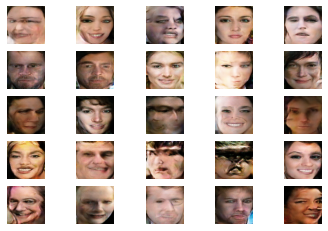

In [101]:

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# create a plot of generated images
def plot_generated(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()


# load model
model = load_model('/content/drive/My Drive/datos/celebridades/generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, 5)

## Interpolación entre rostros generados

In [103]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)



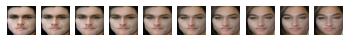

In [105]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy import linspace
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
    # plot images
    for i in range(n):
        # define subplot
        pyplot.subplot(1, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

# load model
model = load_model('/content/drive/My Drive/datos/celebridades/generator_model_100.h5')
# generate points in latent space
pts = generate_latent_points(100, 2)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1])
# generate images
X = model.predict(interpolated)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plot_generated(X, len(interpolated))